In [156]:
#Group: Bohdan Babii, Felix Kreß

# Exercise 6 - Decision Trees

In this exercise we will implement a decision tree classifier and evaluate its performance.

In the event of a persistent problem, do not hesitate to contact the course instructor under

- paul.kahlmeyer@uni-jena.de
- maurice.wenig@uni-jena.de

### Submission
- Deadline of submission:
28.05.2024 23:59
- Submission on [moodle page](https://moodle.uni-jena.de/course/view.php?id=54249)


### Help
In case you cannot solve a task, you can use the saved values within the `help` directory:
- Load arrays with [Numpy](https://numpy.org/doc/stable/reference/generated/numpy.load.html)
```
np.load('help/array_name.npy')
```
- Load functions with [Dill](https://dill.readthedocs.io/en/latest/dill.html)
```
import dill
with open('help/some_func.pkl', 'rb') as f:
    func = dill.load(f)
```

to continue working on the other tasks.

# Dataset

Here we will use a synthetic dataset for binary classification created with scikit learn (see [here](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html)).

### Task 1

Load and display the data located in `X.npy` and `y.npy`.

In [157]:
import numpy as np
import matplotlib.pyplot as plt
import utils
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn import tree

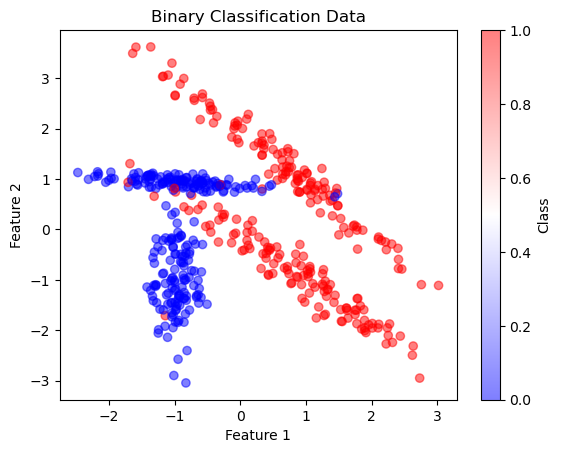

In [158]:
# TODO: load and display data
X, y = np.load('X.npy'), np.load('y.npy')
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.5)  # 'bwr' stands for blue-white-red
plt.title('Binary Classification Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Class')  # Show color bar to indicate classes

# Show the plot
plt.show()

# Decision Trees

Decision trees are data structures, where at each level we make a decision about a feature and at the lowest level we have a decision for a class. For example, consider the following decision tree:
<div>
<img src="images/decision_tree.png" width="800"/>
</div>
You can think of a datapoint trickling down starting at the root and ending up in one of the leaf nodes that assign a class label.

That is, learning a decision tree involves learning which question to ask at which node.

## Learning

Usually we want to select questions in a way that "unmix" the labels of a dataset the best.

As an example, consider a dataset like this:

`X = [1, 2, 3, 4]`, `y = [0, 0, 1, 1]`

Here, we could ask the question: "$X\leq 1$?", which would split the dataset into 

`X1 = [1]`, `y1 = [0]` and 

`X2 = [2, 3, 4]`, `y2 = [0, 1, 1]`.

looking at the labels of the resulting datasets `y1` and `y2`, we can see that `y1` is nicely unmixed (contains only labels of one class). However `y2` is not unmixed.

A better question would be to ask: "$X\leq 2$?", in which case we would get

`X1 = [1, 2]`, `y1 = [0, 0]` and 

`X2 = [3, 4]`, `y2 = [1, 1]`.

Here both `y1` and `y2` are perfectly unmixed.

There are many ways to quantify the "unmixing" property of a dataset. For decision trees however a popular choice is the [**Gini-Impurity**](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity). It measures the probability that we would missclasify a sample if we classified according to the distribution of labels.

Let $p_i$ be the relative frequency of class $i$ in the dataset with labels $y$, then the Gini-Impurity is defined as

\begin{align*}
I_G(y) = 1 - \sum_i p_i^2\,.
\end{align*}

In the following figure we can see the Gini-Impurity for binary classification problems depending on the relative frequency $p_0$ of class 0: 
<div>
<img src="images/gini.png" width="500"/>
</div>
If we have a perfectly unmixed dataset, the Gini-Impurity is 0. The maximum value is 0.5 if we have the same amount of both labels. Recall that for decision trees we want to split a dataset into subsets of low Gini-Impurity.

### Task 2

Implement the following function and calculate the Gini-Impurity for the labels of the dataset.

In [159]:
def gini_imp(y : np.ndarray) -> float:
    '''
    Calculates Gini-Impurity for binary labels.
    
    @Params:
        y... labels in {0, 1}
        
    @Returns: 
        Gini-Impurity
    '''
    # TODO: implement
    y0 = np.mean(y)
    y1 = 1 - y0
    return 1 - y0 * y0 - y1 * y1


# assertions
assert np.isclose(gini_imp(y), 0.499928)

We want to use the Gini-Impurity to evaluate how good a splitting of a dataset is. For this we simply calculate a weighted sum of the impurities of the individual splits. Let $y_0, y_1$ be splits of a dataset $y$. Then we simply compute the score

\begin{align*}
S(y_0, y_1) = \cfrac{|y_0|}{|y_0| + |y_1|}I_G(y_0) + \cfrac{|y_1|}{|y_0| + |y_1|}I_G(y_1)\,.
\end{align*}

That is we weight each the individual impurities with the size of the splits.

### Task 3

Implement the following function and verify the score if we would split the dataset according to the question "$x_0 \leq 0$?".

In [169]:
def gini_imp_split(y0 : np.ndarray, y1 : np.ndarray) -> float:
    '''
    Weighted Gini-Impurity for a split into two sets of labels (binary classification).
    
    @Params:
        y0... label set
        y1... label set
    
    @Returns:
        Impurity score (lower = better)
    '''
    # TODO: implement
    y0Len = len(y0)
    y1Len = len(y1)
    giniY0 = gini_imp(y0)
    giniY1 = gini_imp(y1)
    return (y0Len / (y0Len + y1Len)) * giniY0 + (y1Len / (y0Len + y1Len)) * giniY1


# assertions
mask = X[:, 0] <= 0
y0 = y[mask]
y1 = y[~mask]
assert np.isclose(gini_imp_split(y0, y1), 0.21925534616082165)

Now the challenge is to find the index and the value that produces the lowest score ($\rightarrow$ best split).
For decision trees we do this in three steps:

1. Iterate trough all $x\in X$ and all dimensions $i$. Let $x_i = v$ be the value that we observe.
2. Score the split according to "$x_i \leq v$?".
3. Report dimension $i$ and value $v$ of best score

In practice we do not use the value $v$ but rather the average of $v$ and the first value for $x_i$ that is $> v$. 

As an example, if we identified $x_0 \leq 1.5$ as the best split, we will look for the lowest value of $x_0$ that is $>1.5$ and report the mean of those two values. Lets say this next greater value is $1.6$, then we will report index 0 and value $0.5(1.5 + 1.6) = 1.55$. This way we draw the decision boundary between the datapoints rather than on the datapoints.

### Task 4

Implement the following function that searches for the best split of a dataset.

Use this function to find the best split of our dataset.

In [170]:
def best_split(X : np.ndarray, y : np.ndarray) -> tuple:
    '''
    Identifies the best split of a dataset according to Gini-Impurity.
    
    @Params:
        X... samples
        y... labels
        
    @Returns:
        triple (index, value, Gini-Score) of split
    '''
    # TODO: implement
    minGi = 1
    minV = 0
    minIdx = 0
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            temp1 = X[:,j] <= X[i][j]
            tempGi = gini_imp_split(y[temp1],y[~temp1])
            if minGi > tempGi:
                minGi = tempGi
                minIdx = j
                minV = X[i,j]
    temp1 = X[:, minIdx] > minV
    v = min(X[:, minIdx][temp1])
    return (minIdx, (v + minV)/2, minGi)
                
            

# assertions
idx, v, gi = best_split(X, y)
assert idx == 0
assert np.isclose(v, -0.15385073614765354)
assert np.isclose(gi, 0.19709883984704135)

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


With this functionality we have everything to recursively build up a decision tree.

Each node in the tree has the following attributes:

- `X`, `y`, `gi`: part of the dataset that is passed to the node
- `depth`, `max_depth`: depth of the node in the tree as well as the maximum depth of the tree

And can perform the following operations:

- `split`: if not already pure or at `max_depth`, finds the best split of its dataset and creates two child nodes (+1 depth)
- `predict` : given a dataset predicts labels accoding to its children (or according to its labels if we have no children)

### Task 5

Implement the following `Node` class which implements the functionality of a single node. 

Use the provided `DecisionTree` class to learn and print a decision tree on our dataset.

In [171]:
class Node():
        
    def __init__(self, X : np.ndarray, y : np.ndarray, depth : int, max_depth : int):
        '''
        Constructor for a node.
        
        @Params:
            X... samples
            y... labels
            depth... depth of this node in the tree
            max_depth... maximum depth of any node in the tree
        '''
        self.X = X
        self.y = y
        self.depth = depth
        self.max_depth = max_depth
        
        self.gi = gini_imp(self.y)
        self.split_idx = None
        self.split_value = None
        self.left = None
        self.right = None
        
        
        
    def split(self):
        '''
        Creates child nodes (self.left, self.right) if labels are not already pure.
        '''
        # TODO: implement
        if np.mean(self.y) == 1  or np.mean(self.y) == 0 or self.depth == self.max_depth:
            return
        self.split_idx, self.split_value, _ = best_split(self.X,self.y) 
        cond = self.X[:, self.split_idx] <= self.split_value
        self.left = Node(self.X[cond],self.y[cond],self.depth+1,self.max_depth)
        self.left.split()
        self.right = Node(self.X[~cond],self.y[~cond],self.depth+1,self.max_depth)
        self.right.split()
           
        
    def predict(self, X : np.ndarray) -> np.ndarray:
        '''
        Predicts labels for samples.
        
        @Params:
            X... samples
            
        @Returns:
            predicted labels by this node
        '''
        
        if self.left == None and self.right == None:
            if np.mean(self.y) >= 0.5:
                return np.ones(X.shape[0])
            else:
                return np.zeros(X.shape[0])
        else:
            cond = X[:,self.split_idx] <= self.split_value
            y_left = self.left.predict(X[cond])
            y_right = self.right.predict(X[~cond])
            y=np.empty(X.shape[0])
            y[cond]=y_left
            y[~cond]= y_right
            return y
        
            
        
    def __repr__(self) -> str:
        '''
        String representation of the node.
        
        @Returns:
            a string that represents the subtree with this node as root.
            Something like 
            x0 < 1.5?
                str(child1)
            else
                str(child2)
            
        '''
        ident_str = '\t' * self.depth 
        if self.split_idx is not None:    
            ret = f'{ident_str}x_{self.split_idx} <= {self.split_value}?\n'
            ret += str(self.left)
            ret += f'{ident_str}else:\n'
            ret += str(self.right)
            ret += '\n'
        else:
            ret = f'{ident_str}{np.mean(self.y)}\n'
        return ret


class DecisionTree():
    '''
    Provided. A wrapper class for the root of the decision tree.
    This will give you an idea of how the Node class is used.
    '''
    
    def __init__(self, max_depth : int = np.inf):
        '''
        Constructor of decision tree.
        
        @Params:
            max_depth... maximum depth of any node in the tree
        '''
        self.root = None
        self.max_depth = max_depth
        
    def fit(self, X : np.ndarray, y : np.ndarray):
        '''
        Learns the nodes of the decision tree.
        
        @Params:
            X... samples
            y... labels
        '''
        self.root = Node(X, y, 0, self.max_depth)
        self.root.split()
        
    def predict(self, X : np.ndarray) -> np.ndarray:
        '''
        Predicts labels for samples.
        
        @Params:
            X... samples
        '''
        return self.root.predict(X)
    
    def __repr__(self) -> str:
        '''
        String representation of the tree.
        '''
        return str(self.root)
    
    
# assertions
dt = DecisionTree(2)
dt.fit(X, y)

node = dt.root
assert node.split_idx == 0
assert np.isclose(node.split_value, -0.15385073614765354)

node = dt.root.left
assert node.split_idx == 1
assert np.isclose(node.split_value, 1.2240952599987902)

node = dt.root.right
assert node.split_idx == 0
assert np.isclose(node.split_value, 0.3295256957451717)


print(dt)

x_0 <= -0.15385073614765354?
	x_1 <= 1.2240952599987902?
		0.08235294117647059
	else:
		1.0

else:
	x_0 <= 0.3295256957451717?
		0.7567567567567568
	else:
		0.9783783783783784





### Task 6

Calculate the accuracy of the decision tree on the dataset and visualize the decision boundary.

You can use `utils.plot_dec_boundary` for the visualization.

0.932


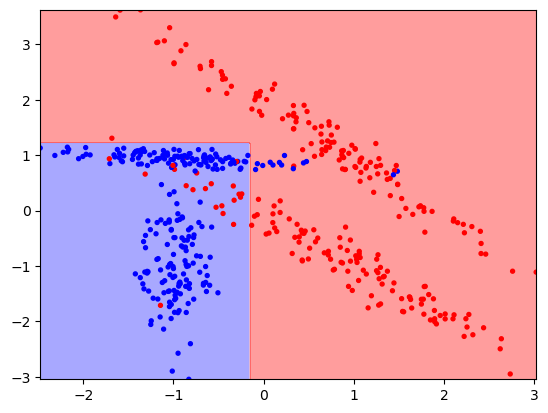

In [163]:
from sklearn.metrics import accuracy_score
# TODO: accuracy
accuracy = accuracy_score(dt.predict(X), y)
print(accuracy)
assert accuracy == 0.932

from utils import plot_dec_boundary 
# TODO: plot decision boundary
plot_dec_boundary(X, y, dt, None)

### Task 7

Use the [scikit learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) to learn a decision tree with the same maximum depth as your tree from Task 5.

Compare the decision boundary, accuracy and the internal parameters to those of your own implementation.

In [164]:
# TODO: use scikit learn implementation
classifier = DecisionTreeClassifier(max_depth=2,random_state=0)
classifier.fit(X,y)

DecisionTreeClassifier(max_depth=2, random_state=0)

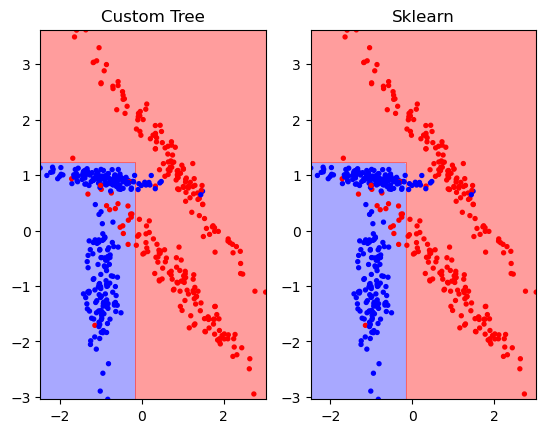

In [165]:
# TODO: compare decision boundary
fig, axs = plt.subplots(ncols = 2)
utils.plot_dec_boundary(X, y, dt, axs[0])
axs[0].set_title('Custom Tree')
utils.plot_dec_boundary(X, y, classifier, axs[1])
axs[1].set_title('Sklearn')
plt.show()

In [166]:
# TODO: compare accuracy
acc = np.mean(classifier.predict(X) == y)
print(f'Accuracy: {acc}')

Accuracy: 0.932


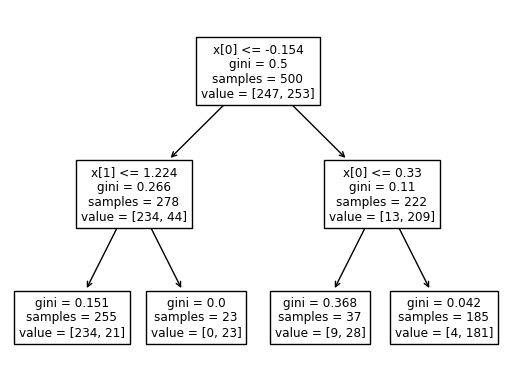

In [167]:
# TODO: compare parameters
tree.plot_tree(classifier)
plt.show()

## Influence of Tree depth

Now we want to investigate the influence of the maximum tree depth on the classification accuracy.

### Task 8

Split the dataset into train- and testdata and plot the train- and test accuracy for an increasing maximum tree depth.

You can use the scikit learn implementation or your own.

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 668.04it/s]


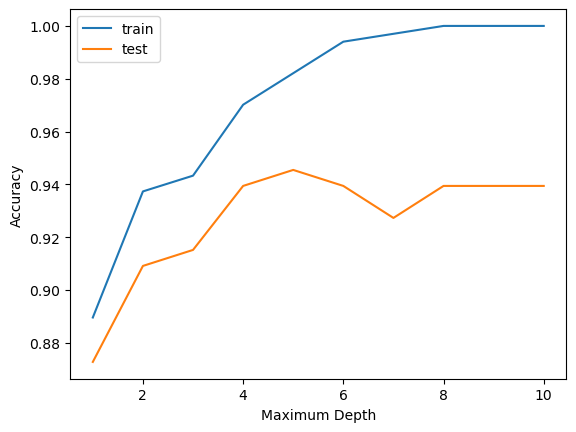

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

# TODO: plot train and test accuracy for increasing tree depth
depths = np.arange(1, 11)
train_accuracy = []
test_accuracy = []
for depth in tqdm(depths):
    dt = DecisionTreeClassifier(max_depth = depth, random_state = 0).fit(X_train, y_train)
    acc = np.mean(dt.predict(X_train) == y_train)
    train_accuracy.append(acc)
    acc = np.mean(dt.predict(X_test) == y_test)
    test_accuracy.append(acc)
    
plt.plot(depths, train_acc, label = 'train')
plt.plot(depths, test_acc, label = 'test')
plt.xlabel('Maximum Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Task 9

In your own words, describe the influence of the maximum tree depth.

<font color='red'>TODO:</font>
The maximum tree depth in decision trees controls the complexity of the model, affecting its ability to generalize to new data. A deeper tree can capture more detailed data patterns, but risks overfitting, whereas a shallower tree may underfit but provides broader generalizability.